In [11]:
install.packages('distributions3')

library(tidyverse)
library(lubridate)
library(tidymodels)
library(distributions3)
library(repr)
library(ggraph)
library(ggpmisc)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.3.6      ✔ purrr   0.3.4 
✔ tibble  3.1.8      ✔ dplyr   1.0.10
✔ tidyr   1.2.1      ✔ stringr 1.4.1 
✔ readr   2.1.2      ✔ forcats 0.5.2 
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Attaching package: ‘lubridate’


The following objects are masked from ‘package:base’:

    date, intersect, setdiff, union


── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.1     ✔ rsample      1.1.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.3     ✔ workflows    1.0.0
✔ modeldata    1.0.1     ✔ workflowsets 1.0.0
✔ parsnip      1.0.1     ✔ yardstick    1.1.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidym

## Functions for probability calculation

## miscellanious functions

In [12]:
# This function is used to obtain the correct Venue for the simulation
isNeutralAdjusted = function(country, opponent, game_name) {
  
  HOSTCOUNTRY = NULL
  
  if(game_name == 'World Cup 2010') {
    HOSTCOUNTRY = 'South Africa'
  } else if(game_name == 'World Cup 2014') {
    HOSTCOUNTRY = 'Brazil'
  } else if(game_name == 'World Cup 2018') {
    HOSTCOUNTRY = 'Russia'
  } else if(game_name == 'World Cup 2022') {
    HOSTCOUNTRY = 'Qatar'
  } 
  
  if (!is.null(HOSTCOUNTRY)) {
    venue = 'N'
    if(country != HOSTCOUNTRY & opponent != HOSTCOUNTRY) {
      return('N')
    } else if(country == HOSTCOUNTRY) {
      return('H')
    } else if(opponent == HOSTCOUNTRY) {
      return('A')
    }
  } else {
    return ('H/A')
  }
}
      
# Custom function that is similar to the ternary operator of other programming languages
ternary = function(expression_1, expression_2, condition) {
  if(condition) {
    expression_1
  } else {
    expression_2
  }
}

## getGoals Function and its dependent functions

In [13]:
# getFifaRanking - The simulation fetches the current fifa ranking depending on what country and date is provided
getFifaRanking = function(country, date) {
    
  fifa_ranking1 %>%
    filter(Land == country) %>%
    filter(fifa_date == date) %>%
    pluck(2) -> temp
  
  as.numeric(temp)
}

# test_date - The simulation uses this function to obtain the current fifa date of the recent update of the fifa ranking

test_date = function(date_param) {
  i = 1;
  
  is_lower = F
    
  date_list = unique(fifa_ranking1$fifa_date)
    
  date_list
  
  # loops through a date_list which we got from the fifa ranking dataset
  for(i in 1:length(date_list)) {
    # test if the supplied date_param is smaller then the fifa_date inside date_list
    # if it is, the loop will break, which means it stops and jumps out of the loop
    if(date_list[i] > date_param) {
      is_lower = F
      break;
    } else {
      is_lower = T
    }
  }
  # This is were the execution continous when we break out of the loop
  # This is also the place where we continue execution in case the for loop finishes through all iterations
  if(i != 1 & is_lower == F) {
    # if i does not stay 1 & a date value was found which exceeds the date_param then
    # it should always return the value at position i - 1
    return(date_list[i-1])
  } else if( i != 1 & is_lower == T) {
    # if i does not stay 1 & a date value was not found which exceeds the date_param then
    # it should always return the value at position i
    return(date_list[i])
  } else {
    # if i does stay 1 it should always return 1
    return(date_list[1])
  }
}

# get goals - This function is used by the simulation to obtain a random poission variable based on the data provided

getGoals = function(df, model, team, opponent, date) {
  # obtains the fifa date that comes before the date paramter
  fifa_date = test_date(date)
  
  dataFrame = data.frame(
    rank_opponent = getFifaRanking(opponent, fifa_date),
    Venue_H = ternary(1, 0, isNeutralAdjusted(team, opponent, 'World Cup 2018') == 'H'),
    Venue_N = ternary(1, 0, isNeutralAdjusted(team, opponent, 'World Cup 2018') == 'N'),
    Rank = getFifaRanking(team, fifa_date))
  
  lambda = predict(model, newdata = dataFrame, type = "response")
  return (rpois(1, lambda))
}

## getGroupPlaySummary

This function simulates the play of all participants within a group and returns a ranking of all participants. It is sorted by rank.
The Rank is determined by the following rules:
- First the countries are sorted by the amount of points in descending order
- if two countries have the same amount of points, the goal difference is used to sort in descending order
- if both points and goal difference is the same, the total number of goals scored is used to sort in descending order

In [14]:
getGroupPlaySummary = function(df, model, team_A, team_B, team_C, team_D, date) {
  
  team_A_points = 0
  team_B_points = 0
  team_C_points = 0
  team_D_points = 0
  
  goal_difference_A = 0
  goal_difference_B = 0
  goal_difference_C = 0
  goal_difference_D = 0
  
  goals_A = 0
  goals_B = 0
  goals_C = 0
  goals_D = 0
  
  getResult = function(df, model, team, opponent) {
    
    team_goals = getGoals(df, model, team, opponent, date)
    
    opponent_goals = getGoals(df, model, opponent, team, date)
    
    return (c(team_goals, opponent_goals))
  }
  
  update_points = function(goals, team, opponent, team_points_param, opponent_points_param) {
    list_ = goals
    team_points = NULL
    opponent_points = NULL
    
    goals_team = list_[1]
    goals_opponent = list_[2]
    
    if(goals_team > goals_opponent) {
      team_points = team_points_param + 3
      opponent_points = opponent_points_param + 0
    } else if(goals_team < goals_opponent) {
      opponent_points = opponent_points_param + 3
      team_points = team_points_param + 0
    } else if(goals_team == goals_opponent) {
      team_points = team_points_param + 1
      opponent_points = opponent_points_param + 1
    }
    
    return (c(team_points, opponent_points))
  }
  
  update_goal_difference = function(goals, team, opponent, team_goal_difference_param, opponent_goal_difference_param) {
    list_ = goals
    team_goal_difference = NULL
    opponent_goal_difference = NULL
    
    goals_team = list_[1]
    goals_opponent = list_[2]
    
    team_goal_difference = 
      team_goal_difference_param +
      goals_team -
      goals_opponent
    
    opponent_goal_difference = 
      opponent_goal_difference_param +
      goals_opponent -
      goals_team
    
    return (c(team_goal_difference, opponent_goal_difference))
  }
  
  # team A - team B
  goals = getResult(df, model, team_A, team_B)
  points = update_points(goals, team_A, team_B, team_A_points, team_B_points)
  difference = update_goal_difference(goals, team_A, team_B, goal_difference_A, goal_difference_B)

  team_A_points = points[1]
  team_B_points = points[2]
  goal_difference_A = difference[1]
  goal_difference_B = difference[2]
  goals_A = goals_A + goals[1]
  goals_B = goals_B + goals[2]
  
  # team A - team C
  goals = getResult(df, model, team_A, team_C)
  points = update_points(goals, team_A, team_C, team_A_points, team_C_points)
  difference = update_goal_difference(goals, team_A, team_C, goal_difference_A, goal_difference_C)
  team_A_points = points[1]
  team_C_points = points[2]
  goal_difference_A = difference[1]
  goal_difference_C = difference[2]
  goals_A = goals_A + goals[1]
  goals_C = goals_C + goals[2]
  
  # team A - team D
  goals = getResult(df, model, team_A, team_D)
  points = update_points(goals, team_A, team_D, team_A_points, team_D_points)
  difference = update_goal_difference(goals, team_A, team_D, goal_difference_A, goal_difference_D)
  team_A_points = points[1]
  team_D_points = points[2]
  goal_difference_A = difference[1]
  goal_difference_D = difference[2]
  goals_A = goals_A + goals[1]
  goals_D = goals_D + goals[2]
  
  # team B - team C
  goals = getResult(df, model, team_B, team_C)
  points = update_points(goals, team_B, team_C, team_B_points, team_C_points)
  difference = update_goal_difference(goals, team_B, team_C, goal_difference_B, goal_difference_C)
  team_B_points = points[1]
  team_C_points = points[2]
  goal_difference_B = difference[1]
  goal_difference_C = difference[2]
  goals_B = goals_B + goals[1]
  goals_C = goals_C + goals[2]
  
  # team B - team D
  goals = getResult(df, model, team_B, team_D)
  points = update_points(goals, team_B, team_D, team_B_points, team_D_points)
  difference = update_goal_difference(goals, team_B, team_D, goal_difference_B, goal_difference_D)
  team_B_points = points[1]
  team_D_points = points[2]
  goal_difference_B = difference[1]
  goal_difference_D = difference[2]
  goals_B = goals_B + goals[1]
  goals_D = goals_D + goals[2]
  
  # team C - team D
  goals = getResult(df, model, team_B, team_D)
  points = update_points(goals, team_C, team_D, team_C_points, team_D_points)
  difference = update_goal_difference(goals, team_C, team_D, goal_difference_C, goal_difference_D)
  team_C_points = points[1]
  team_D_points = points[2]
  goal_difference_C = difference[1]
  goal_difference_D = difference[2]
  goals_C = goals_C + goals[1]
  goals_D = goals_D + goals[2]
  
  data.frame(
    Country=c(team_A, team_B, team_C, team_D),
    Points=c(team_A_points, team_B_points, team_C_points, team_D_points),
    Goal_difference=c(goal_difference_A, goal_difference_B, goal_difference_C, goal_difference_D),
    Goals_scored=c(goals_A, goals_B, goals_C, goals_D)
  ) -> ranking
  
  ranking %>%
    group_by(Points) %>%
    arrange(desc(Goal_difference), desc(Goals_scored), .by_group = T) %>%
    arrange(desc(Points)) -> ranking
  
  return (ranking)
}

## getPlaySummary and its dependent functions

This function simulates the play of two teams and returns the winning team. Who wins is determined by the following rules:

- If team A has more goals scored than team B, it is returned as winner
- If both scored the same amount of goals, the function penaltyShootout is used to determine the winner
    - If after a penalty shootout the scores are still the same, the penaltyShootout function is repeated until a winner is found

In [15]:
penaltyShootout = function() {
  goals_team_A = 0
  goals_team_B = 0
  possibilities = c('goal', 'no_goal')
  sample(possibilities, size=1)
  
  for(i in 1:5) {
    if(sample(possibilities, size=1) == 'goal') {
      goals_team_A = goals_team_A + 1
    }
    
    if(sample(possibilities, size=1) == 'no_goal') {
      goals_team_B = goals_team_B + 1
    }
  }
  
  return (c(
    result_team_A = goals_team_A,
    result_team_B = goals_team_B
  )) 
}

getPlaySummary = function(df, model, team_A, team_B, date) {
  
  result = c()
  country = c()
  opponent = c()
  
  team_A_goals = 0
  team_B_goals = 0
  
  getResult = function(df, model, team, opponent, date) {
    
    team_goals = getGoals(df, model, team, opponent, date)
    
    opponent_goals = getGoals(df, model, opponent, team, date)
    
    return (c('team'=team_goals, 'opponent'=opponent_goals))
  }
  
  # team A - team B
  goals = getResult(df, model, team_A, team_B, date)
  
  winning_team = NULL
  value = 0
  
  penaltyGoals = list(
    result_team_A = 0,
    result_team_B = 0
  )
  
  team_A_goals = team_A_goals + as.numeric(unname(goals['team']))
  team_B_goals = team_B_goals + as.numeric(unname(goals['opponent']))
  
  if(team_A_goals > team_B_goals) {
    value = 1
    winning_team = team_A
  } else if (team_A_goals < team_B_goals) {
    value = 2
    winning_team = team_B
  } else if (team_A_goals == team_B_goals) {
    value = 3
    penaltyGoals = penaltyShootout()
    team_A_goals = team_A_goals + as.numeric(unname(penaltyGoals['result_team_A']))
    team_B_goals = team_B_goals + as.numeric(unname(penaltyGoals['result_team_B']))
    
    while (team_A_goals == team_B_goals) {
      penaltyGoals = penaltyShootout()
      team_A_goals = team_A_goals + as.numeric(unname(penaltyGoals['result_team_A']))
      team_B_goals = team_B_goals + as.numeric(unname(penaltyGoals['result_team_B']))
    }
    
    if(team_A_goals > team_B_goals) {
      winning_team = team_A
    } else {
      winning_team = team_B
    }
  }

  return (winning_team)
}

## Import preprocessed data

In [16]:
data = read.csv('https://raw.githubusercontent.com/denisnaumov0506/FootballAnalyticsProject/master/data/world_cup%26friendlies_football_en.csv', header= T, sep= ';')
fifa_ranking1 = read.csv("https://raw.githubusercontent.com/denisnaumov0506/FootballAnalyticsProject/master/Whole_FIFA_Ranking.csv", header = TRUE, sep = ",", stringsAsFactors=FALSE, fileEncoding="latin1")

## Data splitting into train and test

The data is split into train and test data set. The train data set is limited to entries that do not contain the game_name World Cup 2022 and whose date_of_play values are not older then 20th of November, 2022. We did this to erase any entries not containing information about goals, as they still lie in the future.

In [17]:
# train test

fifa_ranking1

data %>%
    filter(game_name != 'World Cup 2022' 
           & date_of_play < ('2022-11-20')
          ) -> train

data %>%
    filter(game_name == 'World Cup 2022') -> test

Land,Rang,Punkte,fifa_date
<chr>,<int>,<chr>,<chr>
Spain,1,1588,2009-09-02
Netherlands,2,1376,2009-09-02
Germany,3,1186,2009-09-02
Italy,4,1186,2009-09-02
Russia,5,1129,2009-09-02
England,6,1127,2009-09-02
Argentina,7,1113,2009-09-02
Croatia,8,1101,2009-09-02
France,9,1040,2009-09-02


## training the model

To train our model we used the poisson regression to obtain the lambda, that represents our dataset. The parameters Rank of the team, Rank of the opponent, and the Venue status were used.

In [18]:
#train
data

model = 
    glm(
        goals_country ~ Rank + rank_opponent + Venue_H + Venue_N,
        data,
        family = poisson(link = 'log')
       )
summary(model)

country,fifa_date,Matchday,Time,Venue,Opponent,System_of_play,Attendance,result_left,result_right,game_name,goals_country,goals_enemy,date_of_play,rank_opponent,Rank,Venue_A,Venue_H,Venue_N
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<chr>,<int>,<int>,<chr>,<int>,<int>,<int>,<int>,<int>
Argentina,2009-12-16,NA,2:00 AM,H,Costa Rica,4-4-2 Diamond,19.000,3,2,International Friendlies,3,2,2010-01-27,44,8,0,1,0
Argentina,2010-02-03,NA,2:00 AM,H,Jamaica,4-4-2 Diamond,20.000,2,1,International Friendlies,2,1,2010-02-11,78,8,0,1,0
Argentina,2010-03-03,NA,8:45 PM,A,Germany,4-4-2 double 6,65.152,0,1,International Friendlies,1,0,2010-03-03,5,9,1,0,0
Argentina,2010-04-28,NA,11:00 PM,H,Haiti,4-4-2 Diamond,,4,0,International Friendlies,4,0,2010-05-05,87,7,0,1,0
Argentina,2010-04-28,NA,9:00 PM,H,Canada,4-4-2 Diamond,52.000,5,0,International Friendlies,5,0,2010-05-24,63,7,0,1,0
Argentina,2010-05-26,Group B,4:00 PM,N,Nigeria,4-4-2 Diamond,55.686,1,0,World Cup 2010,1,0,2010-06-12,21,7,0,0,1
Argentina,2010-05-26,Group B,1:30 PM,N,South Korea,4-4-2 Diamond,82.174,4,1,World Cup 2010,4,1,2010-06-17,47,7,0,0,1
Argentina,2010-05-26,Group B,8:30 PM,N,Greece,4-4-2 Diamond,38.891,0,2,World Cup 2010,2,0,2010-06-22,13,7,0,0,1
Argentina,2010-05-26,Round of 16,8:30 PM,N,Mexico,4-4-2 Diamond,84.377,3,1,World Cup 2010,3,1,2010-06-27,17,7,0,0,1



Call:
glm(formula = goals_country ~ Rank + rank_opponent + Venue_H + 
    Venue_N, family = poisson(link = "log"), data = data)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.8266  -1.1876  -0.1969   0.5617   3.7318  

Coefficients:
                Estimate Std. Error z value Pr(>|z|)    
(Intercept)    0.1958458  0.0399740   4.899 9.62e-07 ***
Rank          -0.0088665  0.0007454 -11.895  < 2e-16 ***
rank_opponent  0.0071007  0.0004399  16.141  < 2e-16 ***
Venue_H        0.2695579  0.0377726   7.136 9.58e-13 ***
Venue_N        0.1828919  0.0612309   2.987  0.00282 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for poisson family taken to be 1)

    Null deviance: 3201.9  on 2222  degrees of freedom
Residual deviance: 2807.4  on 2218  degrees of freedom
  (176 observations deleted due to missingness)
AIC: 7001.7

Number of Fisher Scoring iterations: 5


# Simulation functions

## simulateGrouPlay

This function uses the getGroupPlaySummary function to obtain the results of a group play. The simulation runs n times and counts in each iteration how many times a team has been placed first, second, third and fourth. The results are then divided by n to determine the probability. This information is then saved inside a data.frame and returned.

## simulatePlay

This function uses the getPlaySummary function to obtain the results of a one on one game match. The simulation runs n times and counts in each iteration how many times a team has been declared a winner. This is then divided by the number of iterations and returned.

## simulateFinalPlays

This function uses the getPlaySummary function to obtain the results of a one on one game match. The simulation runs n times and counts in each iteration how many times a team has been declared a world cup winner. This is then divided by the number of iterations and returned.

Note that, the function is hard coded with the results from the simulateGroupPlay function. 


In [19]:
simulateGroupPlay = function(iter, df, model, team1, team2, team3, team4, date) {
  first_place1 = 0
  second_place1 = 0
  third_place1 = 0
  fourth_place1 = 0
  
  first_place2 = 0
  second_place2 = 0
  third_place2 = 0
  fourth_place2 = 0
  
  first_place3 = 0
  second_place3 = 0
  third_place3 = 0
  fourth_place3 = 0
  
  first_place4 = 0
  second_place4 = 0
  third_place4 = 0
  fourth_place4 = 0
  
  n = iter
  
  for(i in 1:n) {
    summary = getGroupPlaySummary(df, model, team1, team2, team3, team4, date)
    
    if(summary[1,1] == team1) {
      first_place1 = first_place1 + 1
    } else if (summary[2,1] == team1) {
      second_place1 = second_place1 + 1
    } else if (summary[3,1] == team1) {
      third_place1 = third_place1 + 1
    } else if (summary[4,1] == team1) {
      fourth_place1 = fourth_place1 + 1
    }
    
    if(summary[1,1] == team2) {
      first_place2 = first_place2 + 1
    } else if (summary[2,1] == team2) {
      second_place2 = second_place2 + 1
    } else if (summary[3,1] == team2) {
      third_place2 = third_place2 + 1
    } else if (summary[4,1] == team2) {
      fourth_place2 = fourth_place2 + 1
    }
    
    if(summary[1,1] == team3) {
      first_place3 = first_place3 + 1
    } else if (summary[2,1] == team3) {
      second_place3 = second_place3 + 1
    } else if (summary[3,1] == team3) {
      third_place3 = third_place3 + 1
    } else if (summary[4,1] == team3) {
      fourth_place3 = fourth_place3 + 1
    }
    
    if(summary[1,1] == team4) {
      first_place4 = first_place4 + 1
    } else if (summary[2,1] == team4) {
      second_place4 = second_place4 + 1
    } else if (summary[3,1] == team4) {
      third_place4 = third_place4 + 1
    } else if (summary[4,1] == team4) {
      fourth_place4 = fourth_place4 + 1
    }
    
  }
  
  df = data.frame(
    team1 = c(first_place1/iter, second_place1/iter, third_place1/iter, fourth_place1/iter),
    team2 = c(first_place2/iter, second_place2/iter, third_place2/iter, fourth_place2/iter),
    team3 = c(first_place3/iter, second_place3/iter, third_place3/iter, fourth_place3/iter),
    team4 = c(first_place4/iter, second_place4/iter, third_place4/iter, fourth_place4/iter)
    )
  
  df = setNames(df, c(team1, team2, team3, team4))
  print('finished')
  return(df)
}

simulatePlay = function(iter, team_1, team_2, date) {
  
  vector = c()
  
  for(i in 1:iter) {
    #print(i)
    result = getPlaySummary(test, model, team_A = team_1, team_B = team_2, date)
    vector = append(vector, result)
  }
  
  total = 0
  
  for(item in vector) {
    if(item == team_1) {
      total = total + 1
    }
  }
  
  return(total/iter)
}

simulateFinalPlays = function(iter) {
  
  vec = c(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
  
  for(i in 1:iter) {
    # Round 16
    playSum = getPlaySummary(
      df, model,
      'Netherlands', # A1
      'United States', # B2
      '2022-12-02'
    )
    
    winnerA1_B2 = playSum
    
    playSum = getPlaySummary(
      df, model,
      'Argentina', # C1
      'Denmark', # D2
      '2022-12-02'
    )
    
    winnerC1_D2 = playSum
    
    playSum = getPlaySummary(
      df, model, 
      'Spain', #E1
      'Morocco', #F2
      '2022-12-02'
    )
    
    winnerE1_F2 = playSum
    
    playSum = getPlaySummary(
      df, model, 
      'Brazil', #G1
      'South Korea', #H2
      '2022-12-02'
    )
    
    winnerG1_H2 = playSum
    
    playSum = getPlaySummary(
      df, model,
      'Senegal', # A2
      'England', # B1
      '2022-12-02'
    )
    
    winnerB1_A2 = playSum
    
    playSum = getPlaySummary(
      df, model,
      'Mexico', # C2
      'France', # D1
      '2022-12-02'
    )
    
    winnerD1_C2 = playSum
    
    playSum = getPlaySummary(
      df, model,
      'Germany', #E2
      'Belgium', #F1
      '2022-12-02'
    )
    
    winnerF1_E2 = playSum
    
    playSum = getPlaySummary(
      df, model, 
      'Switzerland', #G2
      'Portugal', #H1
      '2022-12-02'
    )
    
    winnerH1_G2 = playSum
    
    # Viertelfinal
    playSum = getPlaySummary(
      df, model,
      winnerA1_B2,
      winnerC1_D2,
      '2022-12-02'
    )
    
    winnerQFA = playSum
    
    playSum = getPlaySummary(
      df, model,
      winnerE1_F2,
      winnerG1_H2,
      '2022-12-02'
    )
    
    winnerQFB = playSum
    
    playSum = getPlaySummary(
      df, model,
      winnerB1_A2,
      winnerD1_C2,
      '2022-12-02'
    )
    
    winnerQFC = playSum
    
    playSum = getPlaySummary(
      df, model,
      winnerF1_E2,
      winnerH1_G2,
      '2022-12-02'
    )
    
    winnerQFD = playSum
    
    # Semi final
    playSum = getPlaySummary(
      df, model,
      winnerQFA,
      winnerQFB,
      '2022-12-02'
    )
    
    winnerSFA = playSum
    
    playSum = getPlaySummary(
      df, model,
      winnerQFC,
      winnerQFD,
      '2022-12-02'
    )
    
    winnerSFB = playSum
    
    # final
    playSum = getPlaySummary(
      df, model,
      winnerSFA,
      winnerSFB,
      '2022-12-02'
    )
    
    winnerF = playSum
    #print(sprintf("The winner of the world cup is: %s", winnerF))
    if(winnerF == 'Netherlands') {
      vec[1] = vec[1] + 1
    } else if(winnerF == 'United States') {
      vec[2] = vec[2] + 1
    } else if(winnerF == 'Argentina') {
      vec[3] = vec[3] + 1
    } else if(winnerF == 'Denmark') {
      vec[4] = vec[4] + 1
    } else if(winnerF == 'Spain') {
      vec[5] = vec[5] + 1
    } else if(winnerF == 'Morocco') {
      vec[6] = vec[6] + 1
    } else if(winnerF == 'Brazil') {
      vec[7] = vec[7] + 1
    } else if(winnerF == 'South Korea') {
      vec[8] = vec[8] + 1
    } else if(winnerF == 'Senegal') {
      vec[9] = vec[9] + 1
    } else if(winnerF == 'England') {
      vec[10] = vec[10] + 1
    } else if(winnerF == 'Mexico') {
      vec[11] = vec[11] + 1
    } else if(winnerF == 'France') {
      vec[12] = vec[12] + 1
    } else if(winnerF == 'Germany') {
      vec[13] = vec[13] + 1
    } else if(winnerF == 'Belgium') {
      vec[14] = vec[14] + 1
    } else if(winnerF == 'Switzerland') {
      vec[15] = vec[15] + 1
    } else if(winnerF == 'Portugal') {
      vec[16] = vec[16] + 1
    }
  }
  df = data.frame(
    Netherlands = vec[1]/iter,
    United_States = vec[2]/iter,
    Argentina = vec[3]/iter,
    Denmark = vec[4]/iter,
    Spain = vec[5]/iter,
    Morocco = vec[6]/iter,
    Brazil = vec[7]/iter,
    South_Korea = vec[8]/iter,
    Senegal = vec[9]/iter,
    England = vec[10]/iter,
    Mexico = vec[11]/iter,
    France = vec[12]/iter,
    Germany = vec[13]/iter,
    Belgium = vec[14]/iter,
    Switzerland = vec[15]/iter,
    Portugal = vec[16]/iter
  )
  
  return(df)
}

# Simulating the Group Play for all groups to determine the most likely contestents for round 16

We set the seed for the rpois function to 1000. We did this to make the simulation reproducable. The seed number was chosen at random. A simulation has been run for all 8 groups.

In [20]:
set.seed(1000)

groupA = simulateGroupPlay(iter = 1000, test, model, 'Netherlands', 'Senegal', 'Ecuador', 'Qatar', '2022-11-29')
groupB = simulateGroupPlay(iter = 1000, test, model, 'England', 'United States', 'Iran', 'Wales', '2022-11-29')
groupC = simulateGroupPlay(iter = 1000, test, model, 'Argentina', 'Poland', 'Saudi Arabia', 'Mexico', '2022-11-30')
groupD = simulateGroupPlay(iter = 1000, test, model, 'France', 'Australia', 'Denmark', 'Tunisia', '2022-11-30')
groupE = simulateGroupPlay(iter = 1000, test, model, 'Germany', 'Spain', 'Japan', 'Costa Rica', '2022-12-01')
groupF = simulateGroupPlay(iter = 1000, test, model, 'Belgium', 'Canada', 'Croatia', 'Morocco', '2022-12-01')
groupG = simulateGroupPlay(iter = 1000, test, model, 'Switzerland', 'Cameroon', 'Serbia', 'Brazil', '2022-12-02')
groupH = simulateGroupPlay(iter = 1000, test, model, 'Portugal', 'Ghana', 'Uruguay', 'South Korea', '2022-12-02')

An example of a group result is shown here:

In [21]:
groupA

X,Netherlands,Senegal,Ecuador,Qatar
<int>,<chr>,<chr>,<chr>,<chr>
1,"0,462","0,302","0,154","0,082"
2,"0,287","0,316","0,228","0,169"
3,"0,155","0,228","0,352","0,265"
4,"0,096","0,154","0,266","0,484"


## After Simulating, the results were saved to a csv file and uploaded to GitHub. We did this, so we did not have to redo the simulation each time.

In [30]:
write.csv2(groupA, file="./groupA_results_football_en.csv")
write.csv2(groupB, file="./groupB_results_football_en.csv")
write.csv2(groupC, file="./groupC_results_football_en.csv")
write.csv2(groupD, file="./groupD_results_football_en.csv")
write.csv2(groupE, file="./groupE_results_football_en.csv")
write.csv2(groupF, file="./groupF_results_football_en.csv")
write.csv2(groupG, file="./groupG_results_football_en.csv")
write.csv2(groupH, file="./groupH_results_football_en.csv")

write.csv2(groupA, file="./groupA_results_occurencies_football_en.csv")
write.csv2(groupB, file="./groupB_results_occurencies_football_en.csv")
write.csv2(groupC, file="./groupC_results_occurencies_football_en.csv")
write.csv2(groupD, file="./groupD_results_occurencies_football_en.csv")
write.csv2(groupE, file="./groupE_results_occurencies_football_en.csv")
write.csv2(groupF, file="./groupF_results_occurencies_football_en.csv")
write.csv2(groupG, file="./groupG_results_occurencies_football_en.csv")
write.csv2(groupH, file="./groupH_results_occurencies_football_en.csv")

## Obtain the results of all groups from GitHub

In [3]:
groupA = read.csv("https://raw.githubusercontent.com/denisnaumov0506/FootballAnalyticsProject/master/data/GroupResults/groupA_results_football_en.csv", header = T, sep = ";")
groupB = read.csv("https://raw.githubusercontent.com/denisnaumov0506/FootballAnalyticsProject/master/data/GroupResults/groupB_results_football_en.csv", header = T, sep = ";")
groupC = read.csv("https://raw.githubusercontent.com/denisnaumov0506/FootballAnalyticsProject/master/data/GroupResults/groupC_results_football_en.csv", header = T, sep = ";")
groupD = read.csv("https://raw.githubusercontent.com/denisnaumov0506/FootballAnalyticsProject/master/data/GroupResults/groupD_results_football_en.csv", header = T, sep = ";")
groupE = read.csv("https://raw.githubusercontent.com/denisnaumov0506/FootballAnalyticsProject/master/data/GroupResults/groupE_results_football_en.csv", header = T, sep = ";")
groupF = read.csv("https://raw.githubusercontent.com/denisnaumov0506/FootballAnalyticsProject/master/data/GroupResults/groupF_results_football_en.csv", header = T, sep = ";")
groupG = read.csv("https://raw.githubusercontent.com/denisnaumov0506/FootballAnalyticsProject/master/data/GroupResults/groupG_results_football_en.csv", header = T, sep = ";")
groupH = read.csv("https://raw.githubusercontent.com/denisnaumov0506/FootballAnalyticsProject/master/data/GroupResults/groupH_results_football_en.csv", header = T, sep = ";")

## The results of the group play should be interpreted as follows:

- Each row represents the placement/position of a country according to their points/goal difference and over all total goals.
- The values are in precentage, which means it shows how often or how likely it is for a country to be placed first, second, third or last.
- From the example below, the Netherlands has a probability of 46.2 % to be placed first, which is also the highest within that row. That means that the Netherlands has the highest change of being placed first.
- Qatar on the other hand has a very low probability with just about 8 % being placed first, its probability being placed last, however, is the highest with 48.4 %.

- Note that, we have selected the highest probability within a postion/place and if a country has the highest probability on both first and second place we took the country with the second highest probability as second place.

## According to these rules we determined who is most likely going to play in Round 16, which yields the following composition

In [6]:
groupA #-> 1. Netherlands, 2. Senegal
groupB #-> 1. England, United States
groupC #->  1. Argentina, 2. Mexico
groupD #-> 1.France, 2. Denmark
groupE #-> 1. Spain, 2. Germany
groupF #-> 1. Belgium, 2. Morocco
groupG #-> 1. Brazil, 2. Switzerland
groupH #-> 1. Portugal, 2. South Korea

X,Netherlands,Senegal,Ecuador,Qatar
<int>,<chr>,<chr>,<chr>,<chr>
1,"0,462","0,302","0,154","0,082"
2,"0,287","0,316","0,228","0,169"
3,"0,155","0,228","0,352","0,265"
4,"0,096","0,154","0,266","0,484"


X,England,United.States,Iran,Wales
<int>,<chr>,<chr>,<chr>,<chr>
1,"0,35","0,255","0,209","0,186"
2,"0,286","0,252","0,217","0,245"
3,"0,192","0,248","0,292","0,268"
4,"0,172","0,245","0,282","0,301"


X,Argentina,Poland,Saudi.Arabia,Mexico
<int>,<chr>,<chr>,<chr>,<chr>
1,"0,428","0,197","0,095","0,28"
2,"0,296","0,267","0,159","0,278"
3,"0,172","0,284","0,29","0,254"
4,"0,104","0,252","0,456","0,188"


X,France,Australia,Denmark,Tunisia
<int>,<chr>,<chr>,<chr>,<chr>
1,"0,438","0,108","0,252","0,202"
2,"0,272","0,194","0,279","0,255"
3,"0,172","0,261","0,277","0,29"
4,"0,118","0,437","0,192","0,253"


X,Germany,Spain,Japan,Costa.Rica
<int>,<chr>,<chr>,<chr>,<chr>
1,"0,302","0,37","0,222","0,106"
2,"0,294","0,296","0,261","0,149"
3,"0,235","0,194","0,3","0,271"
4,"0,169","0,14","0,217","0,474"


X,Belgium,Canada,Croatia,Morocco
<int>,<chr>,<chr>,<chr>,<chr>
1,"0,4","0,088","0,225","0,287"
2,"0,288","0,167","0,254","0,291"
3,"0,204","0,305","0,27","0,221"
4,"0,108","0,44","0,251","0,201"


X,Switzerland,Cameroon,Serbia,Brazil
<int>,<chr>,<chr>,<chr>,<chr>
1,"0,24","0,128","0,167","0,465"
2,"0,298","0,18","0,243","0,279"
3,"0,262","0,284","0,28","0,174"
4,"0,2","0,408","0,31","0,082"


X,Portugal,Ghana,Uruguay,South.Korea
<int>,<chr>,<chr>,<chr>,<chr>
1,"0,373","0,064","0,246","0,317"
2,"0,3","0,125","0,287","0,288"
3,"0,216","0,211","0,29","0,283"
4,"0,111","0,6","0,177","0,112"


## Simulating from Round 16 to Final

Here we simulate the matches from Round 16 to the final match using the simulateFinalPlays function.

In [22]:
final_results = simulateFinalPlays(1000)

# Save final_results as csv

In [25]:
write.csv2(final_results, file='./final_results_football_en.csv', row.names = F)

# Load final results from GitHub

In [28]:
final_results = read.csv('https://raw.githubusercontent.com/denisnaumov0506/FootballAnalyticsProject/master/data/FinalResults/final_results_football_en.csv', header = T, sep = ";")
final_results

Netherlands,United_States,Argentina,Denmark,Spain,Morocco,Brazil,South_Korea,Senegal,England,Mexico,France,Germany,Belgium,Switzerland,Portugal
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
"0,074","0,059","0,08","0,054","0,066","0,03","0,107","0,012","0,047","0,067","0,05","0,089","0,045","0,1","0,046","0,074"


# Change to longer format and sort by probability in descending order

In [23]:
final_results %>%
    pivot_longer(
                 cols=c(
                     'Netherlands',
                     'United_States',
                     'Argentina', 
                     'Denmark', 
                     'Spain', 
                     'Morocco',
                     'Brazil', 
                     'South_Korea',
                     'Senegal', 
                     'England', 
                     'Mexico', 
                     'France',
                     'Germany',
                     'Belgium',
                     'Switzerland',
                     'Portugal'),
        names_to='Participants',
        values_to='Probability') -> df

df %>%
  arrange(desc(Probability)) -> df

## Visualizing the calculated probabilities from the simulation of the final games stages

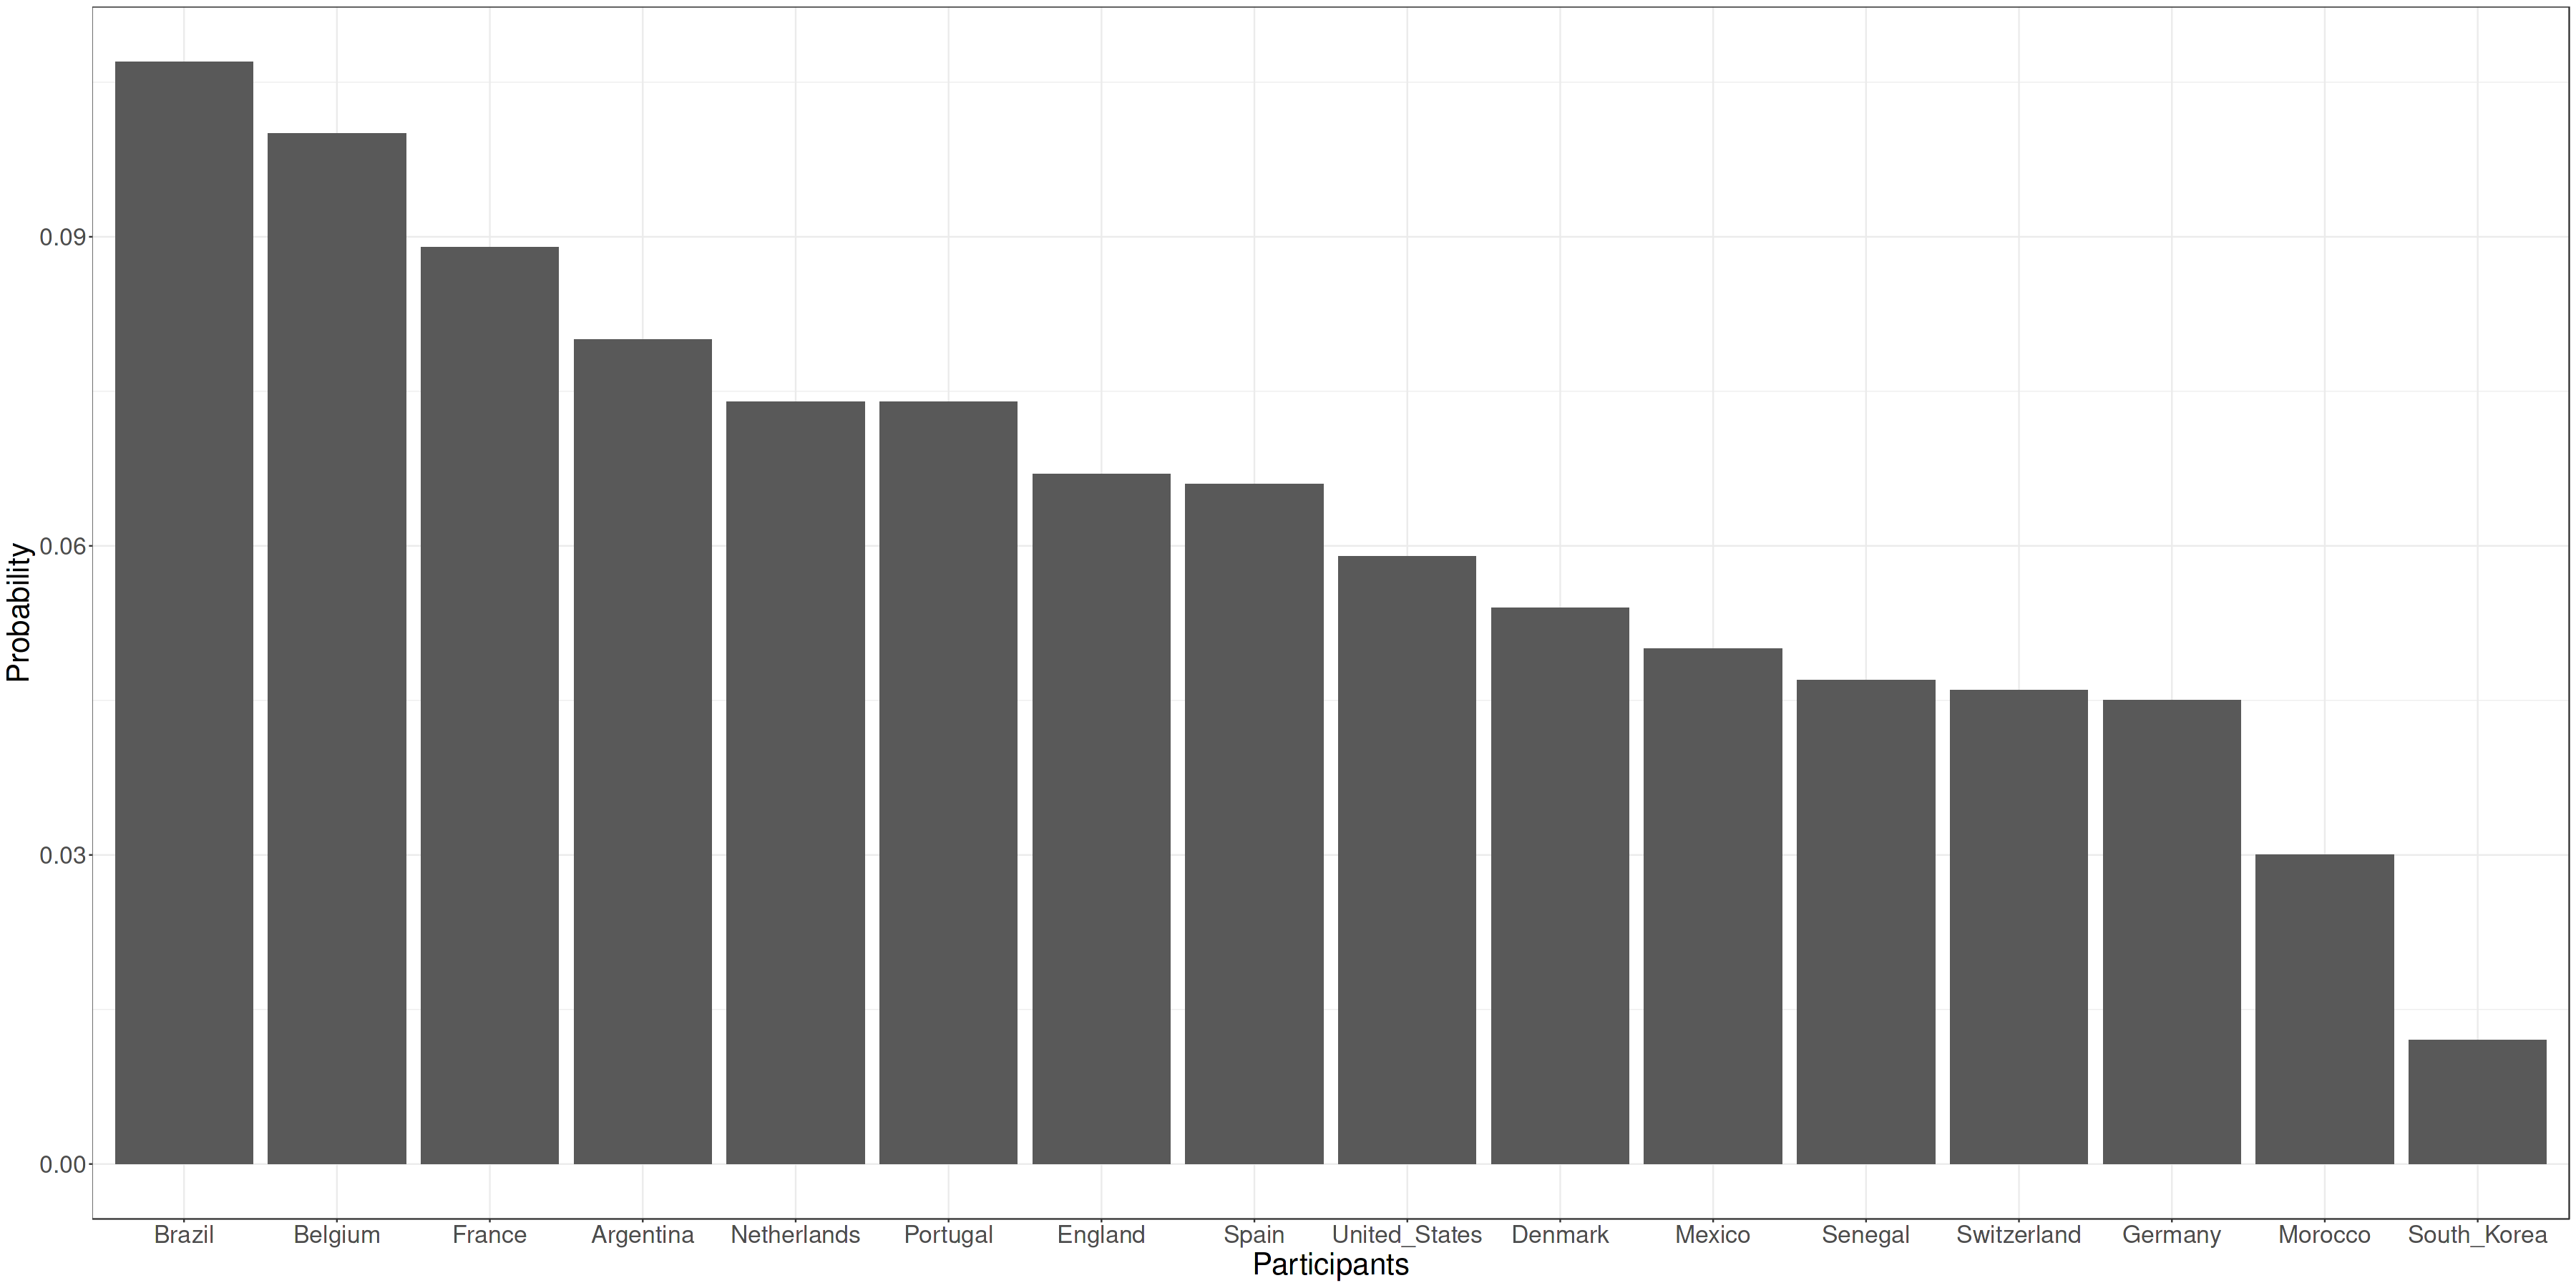

In [24]:
options(repr.plot.width = 30, repr.plot.height = 15)

df %>%
    group_by(Participants) %>%
    arrange(Probability) %>%
    ungroup() %>%
    ggplot() +
        geom_col(aes(x= fct_reorder(Participants, Probability, .desc=T), y=Probability, group=1)) +
        theme_bw() +
        theme(text = element_text(size=25)) +
        labs(x = "Participants")
    

## Calculating the probability for each game of Round 16

In [162]:
Netherlands_US = simulatePlay(1000, 'Netherlands', 'United States', '2022-12-02')
Argentina_Denmark = simulatePlay(1000, 'Argentina', 'Denmark', '2022-12-02')
Spain_Morocco = simulatePlay(1000, 'Spain', 'Morocco', '2022-12-02')
Brazil_SouthKorea = simulatePlay(1000, 'Brazil', 'South Korea', '2022-12-02')
Senegal_England = simulatePlay(1000, 'Senegal', 'England', '2022-12-02')
Mexico_France = simulatePlay(1000, 'Mexico', 'France', '2022-12-02')
Germany_Belgium = simulatePlay(1000, 'Germany', 'Belgium', '2022-12-02')
Switzerland_Portugal = simulatePlay(1000, 'Switzerland', 'Portugal', '2022-12-02')
Netherlands_US #-> 0.538 Netherlands
Argentina_Denmark #-> 0.559 Argentina
Spain_Morocco #-> 0.603 Spain
Brazil_SouthKorea #-> 0.648 Brazil
Senegal_England #-> 0.422 England
Mexico_France #-> 0.469 France
Germany_Belgium #-> 0.447 Belgium
Switzerland_Portugal #-> 0.462 Portugal

## Calculating the probability for each game of Quartal Final

In [184]:
Netherlands_Argentina = simulatePlay(1000, 'Netherlands', 'Argentina', '2022-12-02')
Spain_Brazil = simulatePlay(1000, 'Spain', 'Brazil', '2022-12-02')
England_France = simulatePlay(1000, 'England', 'France', '2022-12-02')
Belgium_Portugal = simulatePlay(1000, 'Belgium', 'Portugal', '2022-12-02')
Netherlands_Argentina #-> 0.473 Argentina
Spain_Brazil #-> 0.467 Brazil
England_France #-> 0.49 France
Belgium_Portugal #-> 0.55 Beglium 

## Calculating the probability for each game of Semi Final

In [188]:
Argentina_Brazil = simulatePlay(1000, 'Argentina', 'Brazil', '2022-12-02')
France_Belgium = simulatePlay(1000, 'France', 'Belgium', '2022-12-02')
Argentina_Brazil #-> 0.483 Brazil
France_Belgium #-> 0.474 Belgium

[1] 0.483

[1] 0.474

## Calculating the probability for Final game

In [190]:
Brazil_Belgium = simulatePlay(1000, 'Brazil', 'Belgium', '2022-12-02')
Brazil_Belgium #-> 0.507 Brazil

[1] 0.507

## Calculating the probability for Third place

In [198]:
France_Argentina = simulatePlay(1000, 'France', 'Argentina', '2022-12-02')
France_Argentina #-> 0.488 Argentina

[1] 0.488

## Putting every probability from round 16 to final game inside data frame

In [211]:
data_R16_to_final = data.frame(
    stage = c(rep('Round_16', 8), rep('Quartal_Final', 4), rep('Semi_Final', 2), 'Third_Place', 'Final'),
    countries = c(
        'Netherlands-United States',
        'Argentina-Denmark',
        'Spain-Morocco',
        'Brazil-South Korea',
        'Senegal-England',
        'Mexico-France',
        'Germany-Belgium',
        'Switzerland-Portugal',
        'Netherlands-Argentina',
        'Spain_Brazil',
        'England-France',
        'Belgium-Portugal',
        'Argentina-Brazil',
        'France-Belgium',
        'France-Argentina',
        'Brazil-Belgium'
    ),
    probabilities = c(
        Netherlands_US,
        Argentina_Denmark,
        Spain_Morocco,
        Brazil_SouthKorea,
        Senegal_England,
        Mexico_France,
        Germany_Belgium,
        Switzerland_Portugal,
        Netherlands_Argentina,
        Spain_Brazil,
        England_France,
        Belgium_Portugal,
        Argentina_Brazil,
        France_Belgium,
        France_Argentina,
        Brazil_Belgium
    )
)

data_R16_to_final

write.csv2(data_R16_to_final, "./data_R16_to_final.csv", row.names=F)

stage,countries,probabilities
<chr>,<chr>,<dbl>
Round_16,Netherlands-United States,0.538
Round_16,Argentina-Denmark,0.559
Round_16,Spain-Morocco,0.603
Round_16,Brazil-South Korea,0.648
Round_16,Senegal-England,0.422
Round_16,Mexico-France,0.469
Round_16,Germany-Belgium,0.447
Round_16,Switzerland-Portugal,0.462
Quartal_Final,Netherlands-Argentina,0.473


# Analysis of results

Brazil and Belgium are most likely to end up in the final with France and Argentina fighting for the third place. We used only 1000 iterations for the simulation part, because 10.000 iterations as it is commonly done in research papers was not possible due to limited hardware. Nonetheless, the results are realistic and promosing.

Obvious drawbacks of this project is the limiting amount of parameters used for the modelling part. Also, 10.000 iterations might have yielded a more accurate representation of the world cup probabilities. In future one could include or replace the fifa ranking with the elo rating and include the probabilities from betting websites to improve upon this model.